# Tramp Steamer Problem
Al Duke 3/11/2022

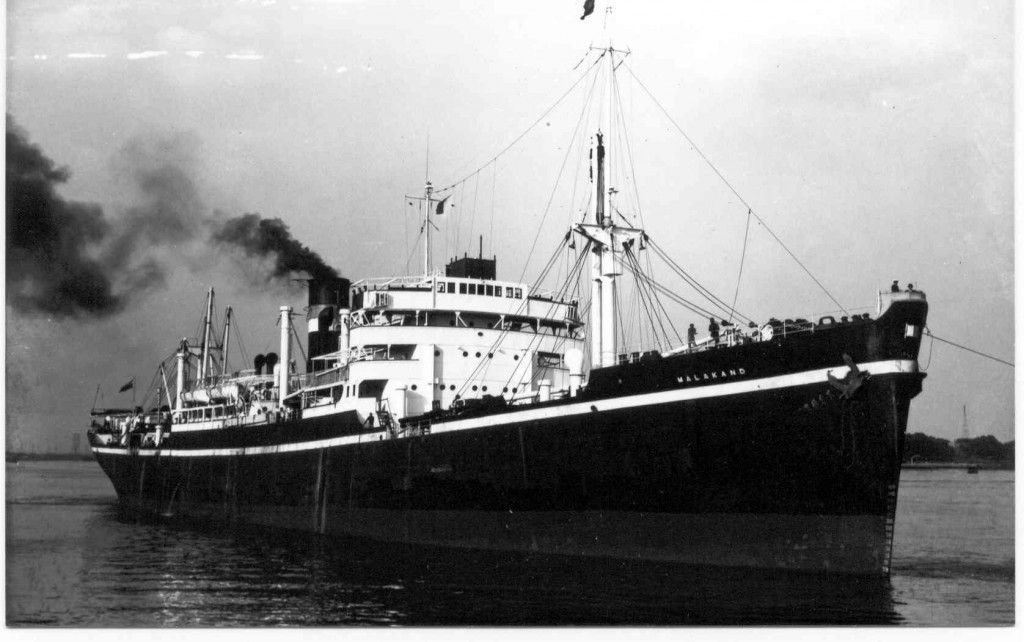
<p style="text-align: center">  <b>Figure 1. Tramp Steamer</b> </p>
Imagine you own a cargo ship that transports goods between ports for profit.  There are several ports and each voyage between ports results in profit p and takes time t. The port-port pairs are determined by goods available at port A and desired at port B. Not all ports are connected and connections are one-way.  You want to find the routes that generate the most profit in the shortest time. 

We can address this problem using Graph Theory. For this problem, we have a directed, weighted graph (digraph) which includes vertices V (ports) and edges E (connections) which have profits p and traversal times t.  Example 1 below shows a simple graph.

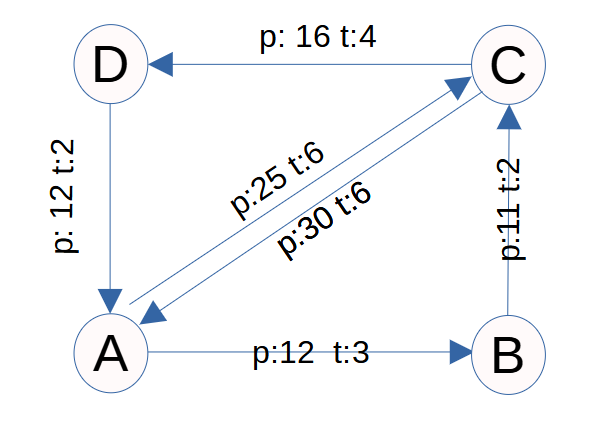
<p style="text-align: center">  <b>Figure 2. Example Graph</b> </p>

I will represent ports(Vertices) as A through D. Note the connections (edges or arcs) between them have arrows indicating direction of travel.  That makes this a "directed graph".  A is connected to B but there is no edge from B to A. Each edge is labeled with a profit (p) and time (t) value.  We need to find the routes (cycles) in this digraph. A cycle (W) starts and ends at the same vertex. For example, A -> B -> C -> A or A -> C -> A.  Profits can be negative and must be integers. Times must be positive integers. 

This type of problem is also known as the "Minimum cost-to-time ratio problem".  Our goal is to find a directed cycle W with maximum ratio of profit to travel time.  However, the algorithms I will use below seek to *minimize* the objective.  To cast this as a minimization problem I will define cost as $c_{i,j}=-p_{i,j}$.   I will then seek to minimize: 

$$\mu (W) = \frac{\sum_{(i,j)\in W}^{}c_{i,j}}{\sum_{(i,j)\in W}^{}t_{i,j} }$$

Using Python code I will capture the details of the digraph in Figure 1.

In [8]:
graph = {
    "A": {"B": (12, 3), "C":(25, 6), },
    "B": {"C": (11, 2),  },
    "C": {"A": (30, 6), "D": (16, 4), },
    "D": {"A": (12, 2), },
    }

I will encode the graph as a python dictionary.  Each vertex is a key.  The value for this key is another dictionary. This dictionary has keys for each connected vertex and values that are tuples containing profit and time for each connection.  For example vertex A is connected to B with a profit of 12 and travel time of 3.  To make the rest of the code clearer, I will decompose the graph into a cost graph (negative profits) and a time graph.  

In [9]:
# decompose graph into separate cost and time graphs
graph_c = {key: {key2: -val2[0] for (key2, val2) in value.items()}
           for (key, value) in graph.items()}
graph_c

{'A': {'B': -12, 'C': -25},
 'B': {'C': -11},
 'C': {'A': -30, 'D': -16},
 'D': {'A': -12}}

In [10]:
graph_t = {key: {key2: val2[1] for (key2, val2) in value.items()}
           for (key, value) in graph.items()}
graph_t

{'A': {'B': 3, 'C': 6}, 'B': {'C': 2}, 'C': {'A': 6, 'D': 4}, 'D': {'A': 2}}

To shorten the search, I want to find only the unique cycles in this graph.

In [11]:
from itertools import permutations

def all_vertices(graph):
    """Return a set of all vertices in a graph.
    
    graph -- a directed graph.
    """
    vertices = set()
    for v in graph.keys():
        vertices.add(v)
        for u in graph[v].keys():
            vertices.add(u)
    return vertices


def is_edge(graph, tail, head):
    """Return True if the edge (tail)->(head) is present in a graph.
    
    graph -- a directed graph.
    tail -- a vertex.
    head -- a vertex.
    """
    return (tail in graph) and (head in graph[tail])


V = tuple(all_vertices(graph))
n = len(V)
all_paths = [path for path_n in range(1, n + 1) 
             for path in permutations(V, path_n)
    if all( is_edge(graph, tail, head)
           for (tail, head) in zip(path, path[1:])
    ) ]

all_cycles = [(*path, path[0]) for path in all_paths
              if is_edge(graph, path[-1], path[0])]

cycles = []
cycle_sets = []
for cycle in all_cycles:
    edges = set(x[0]+x[1] for x in zip(cycle, cycle[1:]))
    if edges not in cycle_sets:
        cycle_sets.append(edges)
        cycles.append(cycle)
        
cycles

[('C', 'A', 'C'),
 ('D', 'A', 'C', 'D'),
 ('B', 'C', 'A', 'B'),
 ('D', 'A', 'B', 'C', 'D')]

I have 4 unique cycles  in this graph.  'Unique' means I eliminate cycles that follow the same path but start at a different vertex.  For example, A -> C -> A is equivalent to C -> A -> C. 

## Sequential Search
The first method I will use the find the minimum cost cycle is called sequential search.  I included a couple of classes to handle the negative cycle case plus some helper functions for path weight, cost to time ratio and a brute force shortest cycle function. 

In [12]:
class NoShortestPathError(Exception):
    pass

class NegativeCycleError(NoShortestPathError):
    def __init__(self, weight, cycle):
        self.weight = weight
        self.cycle = cycle

    def __str__(self):
        return f"Weight {self.weight}: {self.cycle}"


def path_weight(path, graph):
    """Returns the sum of the weights along a path or cycle."""
    return sum(graph[tail][head] for (tail, head) in zip(path, path[1:]))

def cost_time_ratio(cycle, graph_c, graph_t):
    """
    Find cost to time ratio for a cycle. (tramp steamer problem objective)

    Parameters
    ----------
    cycle : list
        directed path that ends where it began
    graph_c : dict
        graph with cost values
    graph_t : dict
        graph with time values

    Returns
    -------
    Ratio of net cost to net travel time for a cycle.

    """
    w = sum(graph_c[tail][head] for (tail, head) in zip(cycle, cycle[1:]) )
    t = sum(graph_t[tail][head] for (tail, head) in zip(cycle, cycle[1:]) )
    return w/t


def shortest_cycle_bf(graph, cycles):
    """Find the shortest cycle in cycles using a brute force approach.
    If a negative cycle exists, raise NegativeCycleError. Otherwise 
    return shortest cycle.
    
    Parameters
    ----------
    graph : dictionary
        A directed, weighted graph.
    cycles : list of tuples
        List of cycles contained in graph.
        
    Returns
    -------
    Tuple with weight and path of the cycle with the lowest weight.
    
    """
    for cycle in cycles:
        weight = path_weight(cycle, graph)
        if weight < 0:
            raise NegativeCycleError(weight, cycle)
            
    return min( (path_weight(path, graph), path) for path in cycles)


def seq_search(graph, cycles, mu=100): 
    """ Perform sequential search of cycles in graph using le = ce - mu * te for edge
    weights. If a Negative weight cycle is found, mu is updated based on this cycle and the 
    process is repeated until no negative cycles are found by the shortest cycle step.
    
    Parameters
    ----------
    graph : dictionary
        A directed, weighted graph.
    cycles : list of tuples
        List of cycles contained in graph.
    mu : float
        Initial cost to weight ratio.  Expected upper bound. 
        
    Returns
    -------
    Cycle with the minimum cost to time ratio and the number of loops required
    to find it. 
    """
    loops = 0  # for algo comparison
    while True:
        loops += 1  # for algo comparison
        # Compute 'length' values for edges: l_e = c_e - mu * t_e
        graph_le = graph.copy()
        for (key, dic) in graph_le.items():
            graph_le[key] = {keyy: -val[0] - mu * val[1]
                             for (keyy, val) in dic.items()}

        try: # find shortest cycle based on le weights
            cycle_weight, W = shortest_cycle_bf(graph_le, cycles)

        except NegativeCycleError as error: # found negative cost cycle w.r.t. le)
            mu = cost_time_ratio(error.cycle, graph_c, graph_t)
            # print('mu ', mu, 'weight ', error.weight)

        else:  # Found a zero cost cycle w.r.t. le.
            optimum = W
            break

    return optimum, loops

opt, loops = seq_search(graph, cycles)
print("loops: ",loops)
print("Optimal path: ", opt)
print("Optimal cost ratio: {:.3f}".format(
            cost_time_ratio(opt, graph_c, graph_t))) 

loops:  3
Optimal path:  ('B', 'C', 'A', 'B')
Optimal cost ratio: -4.818


After 3 passes the sequential algorithm finds an optimal cycle with a profit/time ratio of 4.818.  Worst case time complexity for sequential search is O(|cycles|) or 4 in this case.

# Binary Search
The second algorithm mentioned in [1] is binary search. 

In [13]:
def binary_search(graph, cycles):
        """ Perform binary search of cycles in graph using an initial search
        range of -C to C with C = max(all costs in graph). Search for shortest
        cycle using le = ce - mu * te for the edge weights. If a negative
        cycle is found, set upper end of range to the current cost ratio
        estimate (mu) otherwise set the lower end of the range to mu.
        Terminate the search if the current cycle weight is less than
        the precision. 
        

        Parameters
        ----------
        graph : dict
            a directed, weighted graph.
        cycles : list of tuples
            List of cycles contained in graph..

        Returns
        -------
        optimum : tuple
            Cycle with the minimum cost to time ratio.
        loops : int
            Number of loops required to find minima.

        """
        # define limits for starting range of search
        C =  max([max(val.values()) for key, val in graph_c.items()])  
        mu_lower = C # lower limit to search for min cycle cost ratio. 
        # Since c_i are all negative, need to reverse the signs 
        mu_upper = -C  # upper limit to search for min cycle cost ratio
        loops = 0
        while True:
            loops += 1
            mu = (mu_lower + mu_upper) / 2
        
            #Compute 'length' values for edges: l_e = c_e - mu * t_e
            graph_le = graph.copy()
            for (key, dic) in graph_le.items():
                graph_le[key] = {keyy: -val[0] - mu * val[1]
                                 for (keyy, val) in dic.items()}
                
            try:  # Solve shortest path problem with lengths le
                cycle_weight, W = shortest_cycle_bf(graph_le, cycles)
                # print("c_weight: {:.3g}, range: {:.3g} to {:.3g}, mu: {}".
                #       format(cycle_weight, mu_lower, mu_upper, mu))
        
            except NegativeCycleError as error: # negative cost cycle w.r.t. le': mu_star < mu
                mu_upper = mu
                W = error.cycle
                cycle_weight = error.weight
                # print("*c_weight: {:.3g}, range: {:.3g} to {:.3g}, mu: {}".
                #       format(error.weight, mu_lower, mu_upper, mu))
            else: # mu_star > mu
                mu_lower = mu
            
            finally:
                # precision of 1/sum(t_e) suffices to solve the problem exactly
                precision = 1/ sum(graph_t[tail][head] for (tail, head) in
                                   zip(W, W[1:]) )
                if abs(cycle_weight) < precision: # zero cost cycle, mu_star == mu
                    optimum = W
                    break
                
        return optimum, loops
    
opt, loops = binary_search(graph, cycles)
print("loops: ",loops)
print("Optimal path: ", opt)
print("Optimal cost ratio: {:.3f}".format(
            cost_time_ratio(opt, graph_c, graph_t)))  

loops:  5
Optimal path:  ('B', 'C', 'A', 'B')
Optimal cost ratio: -4.818


Binary search achieves the same result as sequential search but with more loops.  The time complexity is $O(log(\sum t_a |A| |V|))$  or $log(23 * 6 * 4)=6.3$ in this case.  For this simple example, sequential search is more efficient but for more complex graphs binary search should be more efficient.  

References:  
1. Network Flows, Theory, Algorithms and Applications, Ahuja, Magnati and Orlin, 1993, para. 5.7   
2. Blog post by John Lekberg, December 04, 2020. https://johnlekberg.com/blog/2020-12-04-shortest-path.html  
3. Competitive Programming in Python, D&uuml;rr and Vie, 2021, para. 7.4